# Funny vs. Serious Single Sentence Explorer

Analysis of contrastive activations from Llama-3.1-70B-Instruct on the **funny_serious_150** dataset.

**Dataset format:** Single completed sentences `"C_completed."` — the same joke sentence completed with either the serious or funny word.

- 75 pairs (150 prompts total)
- All sentences from straight-dominated jokes
- Token position: the final period (end of sentence)

**Research question:** Does the model represent funny vs. serious sentence endings differently, even when there's no priming context?

**Contents:**
1. Data overview and separation metrics
2. Static visualizations
3. Interactive 3D layer explorer

In [1]:
from pathlib import Path
import json
import numpy as np
from IPython.display import HTML, display
import matplotlib.pyplot as plt
%matplotlib inline

from analyze_activations import (
    load_activations, get_pair_indices, analyze_all_layers,
    contrastive_projection, contrastive_direction, cohens_d,
    stable_contrastive_projections, holdout_analysis,
)
from puns_viz import make_layer_viz

In [2]:
RAW_DIR = Path("results/raw_activations")
DATASET_FILE = Path("datasets/funny_serious_150.json")

# Meta file for funny_serious dataset
META_FILE = RAW_DIR / "llama31_70b_instruct_funnyserious150_pred_c_meta.json"

if not META_FILE.exists():
    print(f"Meta file not found: {META_FILE}")
    print("Run: python3 collect_activations.py --position pred_c --dataset funny_serious_150.json")
else:
    meta, layer_data, layer_indices = load_activations(META_FILE)
    pair_ids, is_funny, is_straight = get_pair_indices(meta)
    
    print(f"Model: {meta['model']}")
    print(f"Dataset: {meta.get('dataset', 'funny_serious_150.json')}")
    print(f"Position: {meta['position']} (sentence-ending period)")
    print(f"Layers: {len(layer_indices)} (0-{layer_indices[-1]})")
    print(f"Prompts: {meta['n_prompts']} ({is_straight.sum()} serious, {is_funny.sum()} funny)")
    print(f"Hidden dim: {meta['hidden_dim']}")

Model: meta-llama/Llama-3.1-70B-Instruct
Dataset: funny_serious_150.json
Position: pred_c (sentence-ending period)
Layers: 80 (0-79)
Prompts: 150 (75 serious, 75 funny)
Hidden dim: 8192


---
## 1. Separation Metrics Across Layers

Does the representation at the sentence-ending period differ based on whether the completion was funny or serious?

In [3]:
layer_results = analyze_all_layers(layer_data, meta)

peak_fisher = layer_results['peak_fisher_layer']
peak_cd = layer_results['peak_cohens_d_layer']
peak_cd_idx = layer_indices.index(peak_cd)

print(f"Fisher peak: layer {peak_fisher} (score={layer_results['fisher'][layer_indices.index(peak_fisher)]:.3f})")
print(f"Cohen's d peak: layer {peak_cd} (d={layer_results['cohens_d'][peak_cd_idx]:.2f})")

Fisher peak: layer 30 (score=0.422)
Cohen's d peak: layer 27 (d=2.94)


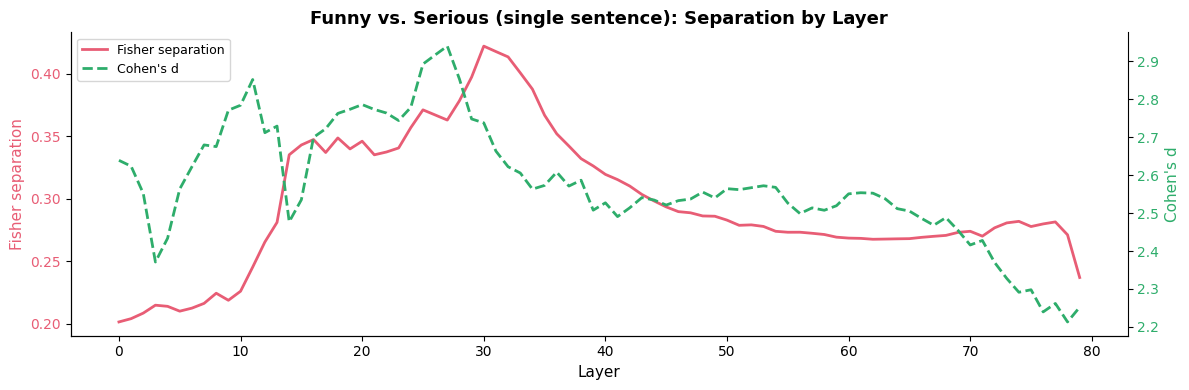

In [4]:
fig, ax1 = plt.subplots(figsize=(12, 4))

ax1.plot(layer_indices, layer_results['fisher'], color='#E85D75', lw=2, label='Fisher separation')
ax1.set_xlabel('Layer', fontsize=11)
ax1.set_ylabel('Fisher separation', fontsize=11, color='#E85D75')
ax1.tick_params(axis='y', labelcolor='#E85D75')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

ax2 = ax1.twinx()
ax2.plot(layer_indices, layer_results['cohens_d'], color='#2EAD6B', lw=2, ls='--', label="Cohen's d")
ax2.set_ylabel("Cohen's d", fontsize=11, color='#2EAD6B')
ax2.tick_params(axis='y', labelcolor='#2EAD6B')
ax2.spines['top'].set_visible(False)

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, fontsize=9, loc='upper left')
ax1.set_title('Funny vs. Serious (single sentence): Separation by Layer', fontsize=13, fontweight='bold')
fig.tight_layout()
plt.show()

---
## 2. Static Visualizations

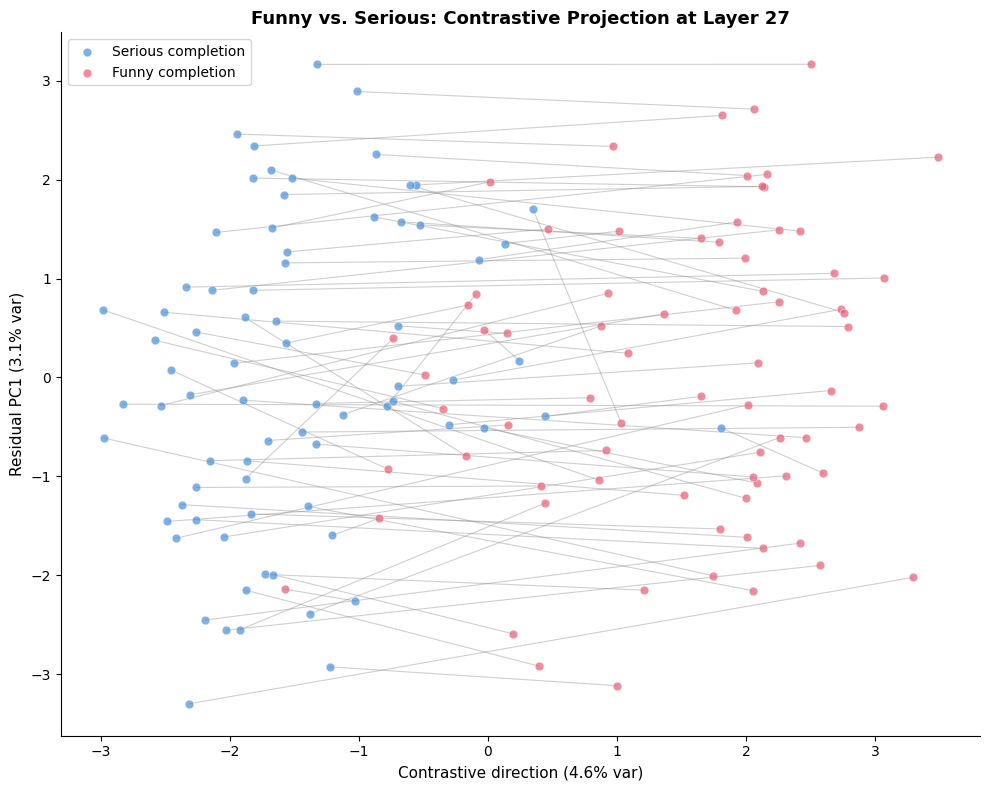

In [5]:
# Contrastive scatter at peak layer
X_peak = layer_data[peak_cd]
X_proj, _, var_ratios = contrastive_projection(X_peak, meta, n_components=2)

fig, ax = plt.subplots(figsize=(10, 8))

# Pair lines
for pid in sorted(set(pair_ids)):
    mask = pair_ids == pid
    if mask.sum() == 2:
        pts = X_proj[mask]
        ax.plot(pts[:, 0], pts[:, 1], color='#888', alpha=0.4, lw=0.8, zorder=1)

# Points
ax.scatter(X_proj[is_straight, 0], X_proj[is_straight, 1], c='#4A90D9', 
           s=40, alpha=0.7, label='Serious completion', edgecolors='white', lw=0.5, zorder=2)
ax.scatter(X_proj[is_funny, 0], X_proj[is_funny, 1], c='#E85D75',
           s=40, alpha=0.7, label='Funny completion', edgecolors='white', lw=0.5, zorder=2)

ax.set_xlabel(f'Contrastive direction ({var_ratios[0]:.1%} var)', fontsize=11)
ax.set_ylabel(f'Residual PC1 ({var_ratios[1]:.1%} var)', fontsize=11)
ax.set_title(f'Funny vs. Serious: Contrastive Projection at Layer {peak_cd}', fontsize=13, fontweight='bold')
ax.legend(fontsize=10, loc='best')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.tight_layout()
plt.show()

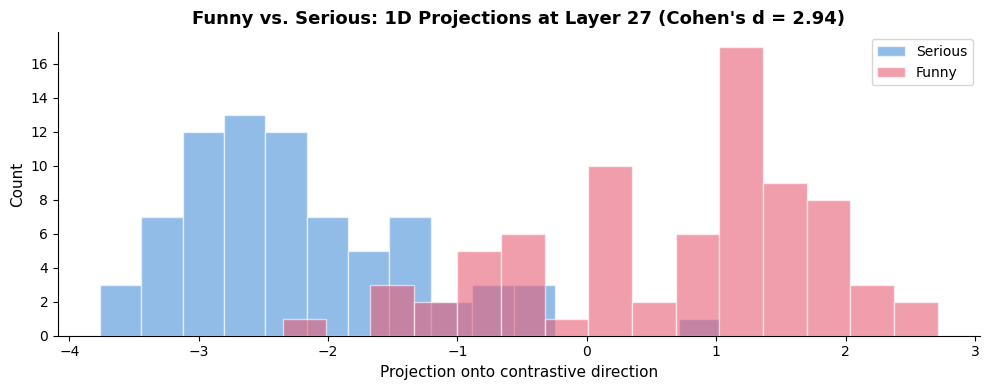

In [6]:
# 1D projection histogram
direction = contrastive_direction(X_peak, meta)
projections = X_peak @ direction

fig, ax = plt.subplots(figsize=(10, 4))
ax.hist(projections[is_straight], bins=15, alpha=0.6, color='#4A90D9', label='Serious', edgecolor='white')
ax.hist(projections[is_funny], bins=15, alpha=0.6, color='#E85D75', label='Funny', edgecolor='white')
ax.set_xlabel('Projection onto contrastive direction', fontsize=11)
ax.set_ylabel('Count', fontsize=11)
ax.set_title(f'Funny vs. Serious: 1D Projections at Layer {peak_cd} (Cohen\'s d = {layer_results["cohens_d"][peak_cd_idx]:.2f})',
             fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.tight_layout()
plt.show()

---
## 3. Interactive 3D Layer Explorer

- **Drag** to rotate
- **Scroll/pinch** to zoom
- **Shift-drag** to pan
- **Layer slider** to move through all layers

In [ ]:
# Note: pred_file=False skips loading predictions because pun boost isn't meaningful
# for this dataset - these are completed sentences, not cloze predictions.
html = make_layer_viz(META_FILE, pred_file=False, width=900, height=600)
HTML(html)

---
## 4. Holdout Analysis

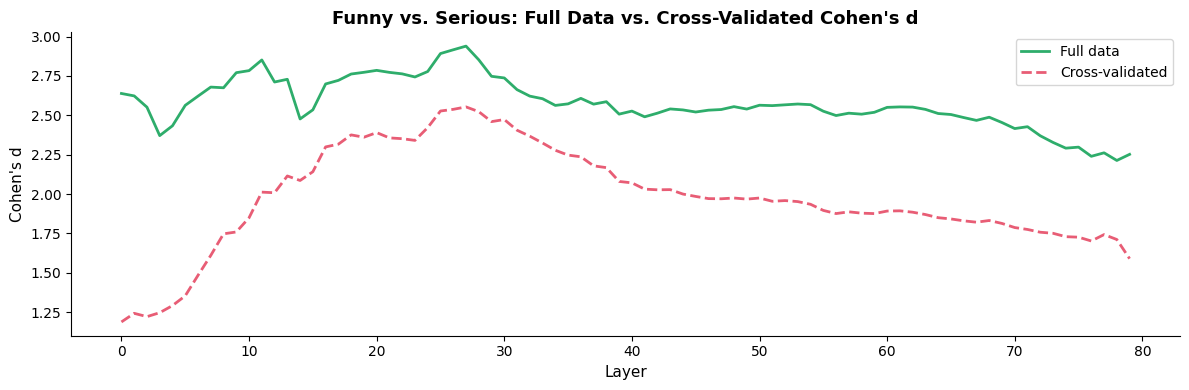

In [8]:
holdout = holdout_analysis(layer_data, meta, n_splits=2, seed=42)

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(holdout['layer_indices'], holdout['cohens_d_full'], color='#2EAD6B', lw=2, label='Full data')
ax.plot(holdout['layer_indices'], holdout['cohens_d_cv'], color='#E85D75', lw=2, ls='--', label='Cross-validated')
ax.set_xlabel('Layer', fontsize=11)
ax.set_ylabel("Cohen's d", fontsize=11)
ax.set_title('Funny vs. Serious: Full Data vs. Cross-Validated Cohen\'s d', fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.tight_layout()
plt.show()

---
## 5. Sample Prompts

View some example prompt pairs to understand the dataset.

In [9]:
with open(DATASET_FILE) as f:
    dataset = json.load(f)

print("Sample prompt pairs:\n")
for i in range(0, min(10, len(dataset)), 2):
    serious = dataset[i]
    funny = dataset[i+1]
    print(f"Pair {serious['pair_id']}:")
    print(f"  Serious: \"{serious['prompt']}\"")
    print(f"  Funny:   \"{funny['prompt']}\"")
    print()

Sample prompt pairs:

Pair 0:
  Serious: "The dangerous iPhone was arrested and charged with assault."
  Funny:   "The dangerous iPhone was arrested and charged with battery."

Pair 1:
  Serious: "The bread was afraid to be best man, because he would have to make a speech."
  Funny:   "The bread was afraid to be best man, because he would have to make a toast."

Pair 2:
  Serious: "The wizard ran a fantastic music school because he had a great passion."
  Funny:   "The wizard ran a fantastic music school because he had a great staff."

Pair 3:
  Serious: "The mushroom's salary never went up because there was always a ceiling."
  Funny:   "The mushroom's salary never went up because there was always a cap."

Pair 4:
  Serious: "The vulture boarded the airplane with two dead raccoons but was told he was only allowed one carry-on."
  Funny:   "The vulture boarded the airplane with two dead raccoons but was told he was only allowed one carrion."

